In [3]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [4]:
!ls

sample_data  track


In [5]:
!pip3 install imgaug

In [0]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Neural Network 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPool2D
# from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.models import Model

# data processing
import os
import ntpath
import cv2
import pandas as pd
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as npimg
from imgaug import augmenters as iaa

# Data
## Data Initialisation

In [7]:
data_dir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1) # Seting column width to max for each column to avoid ellipsis
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438



<br />

### Data Cleaning

#### Removing the irrelevent directory path from each of the images 

In [8]:
def path_leaf(path):
  head, tail = ntpath.split(path) # catch the part after the final slash '\'
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


<br />

#### Data Distribution visualisation

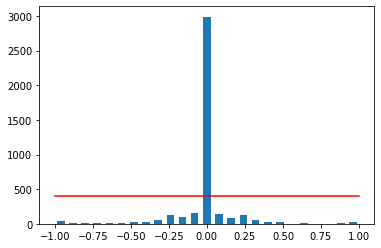

In [9]:
num_bins = 25
max_samples_per_bin = 400

hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:])*0.5
plt.bar(center, hist, width=0.05)

# plot the max samples per bin threshold
plt.plot( (np.min(data['steering']), np.max(data['steering'])), (max_samples_per_bin, max_samples_per_bin), 'r')

#### Removal of heavily biased data

In [10]:
print('Total # data:', len(data))

remove_list = []

for j in range(num_bins):
  list_ = []

  for i in range(len(data['steering'])): # seprating steering angles into its respective bins
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      # if the current steering angle is in the current bin
      list_.append(i)
    
  list_ = shuffle(list_)
  list_ = list_[max_samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))


Total # data: 4053
removed: 2590
remaining: 1463


<br />
Plot the more balanced distribution of steering angles

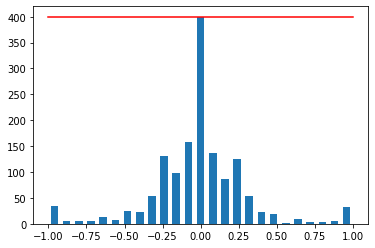

In [11]:
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)

# threshold
plt.plot( (np.min(data['steering']), np.max(data['steering'])), (max_samples_per_bin, max_samples_per_bin), 'r')

Now that the 0 angle bias has been handled appropriatly. Data can be preprocessed. 

<br />

## Data Preprocessing

### Train test split

In [0]:
def load_img_steering(data_dir, df):
  image_path = []
  steering = []

  for i in range(len(df)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(data_dir, center.strip()))
    steering.append(float(indexed_data[3]))
  
  image_path = np.asarray(image_path)
  steering = np.asarray(steering)

  return image_path, steering

In [13]:
image_paths, steerings = load_img_steering(data_dir+'/IMG', data)

X_train, X_val, y_train, y_val =  train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

print('Training samples: {}\nValid Sample: {}\n\n'.format(len(X_train), len(X_val)))
print('Data looks like:\n',X_train)
print(y_train)

Training samples: 1170
Valid Sample: 293


Data looks like:
 ['track/IMG/center_2018_07_16_17_13_35_334.jpg'
 'track/IMG/center_2018_07_16_17_13_54_540.jpg'
 'track/IMG/center_2018_07_16_17_14_27_259.jpg' ...
 'track/IMG/center_2018_07_16_17_12_26_152.jpg'
 'track/IMG/center_2018_07_16_17_13_56_029.jpg'
 'track/IMG/center_2018_07_16_17_14_30_045.jpg']
[ 0.         0.         0.        ... -0.05       0.         0.2621606]


#### Data Distribution

Text(0.5, 1.0, 'Validation Set')

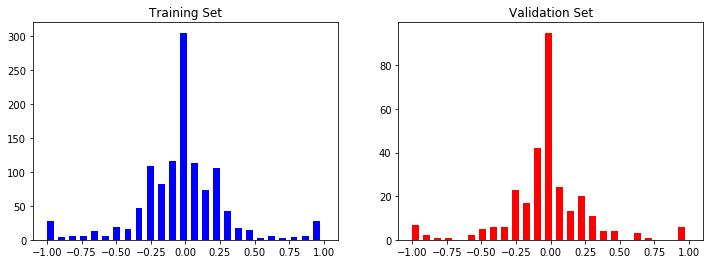

In [14]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
axis[0].hist(y_train, num_bins, width=0.05, color='blue')
axis[0].set_title('Training Set')
axis[1].hist(y_val, num_bins, width=0.05, color='r')
axis[1].set_title('Validation Set')


### Image Augmentation


#### Zoom

In [0]:
# zooming into the images - allowing the model to have a closer look to the features 
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3)) # upto 30x zoom [lower_bound, upper_bound]
  return zoom.augment_image(image)  

Text(0.5, 1, 'Zoomed')

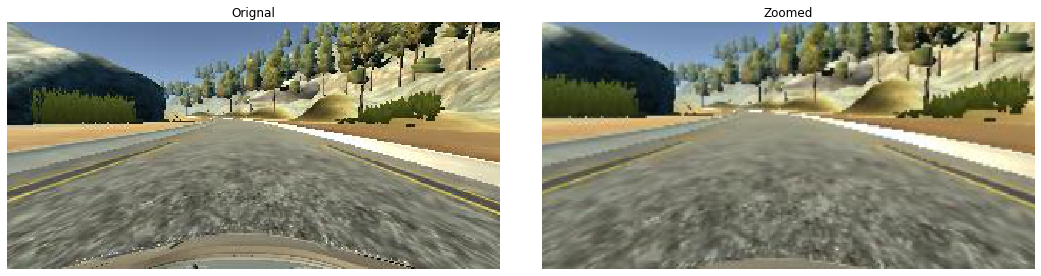

In [16]:
img = image_paths[random.randint(0, 1000)]
original_img = npimg.imread(img)
zoomed_img = zoom(original_img)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_img)
axis[0].axis('off')
axis[0].set_title('Orignal')
axis[1].imshow(zoomed_img)
axis[1].axis('off')
axis[1].set_title('Zoomed')

#### Panning

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent={'x': [-0.1, 0.1], 'y': [-0.1, 0.1]})
  return pan.augment_image(image)

Text(0.5, 1, 'Pannedg')

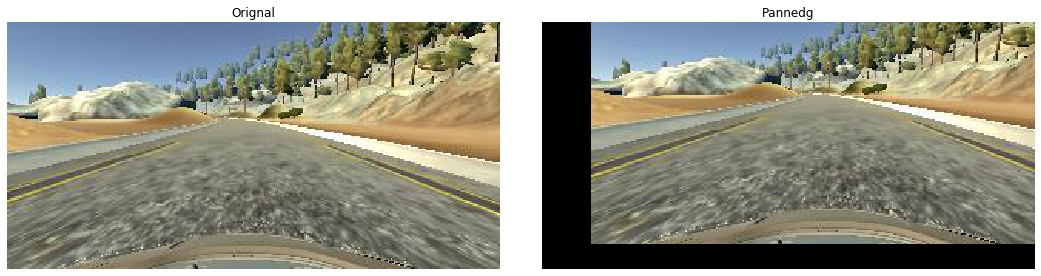

In [18]:
img = image_paths[random.randint(0, 1000)]
original_img = npimg.imread(img)
zoomed_img = pan(original_img)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_img)
axis[0].axis('off')
axis[0].set_title('Orignal')
axis[1].imshow(zoomed_img)
axis[1].axis('off')
axis[1].set_title('Pannedg')

#### Altering Brightness

In [0]:
def img_random_brightness(image):
  brightness = iaa.Multiply([0.2, 1.2])
  return brightness.augment_image(image)

Text(0.5, 1, 'Random Brightness')

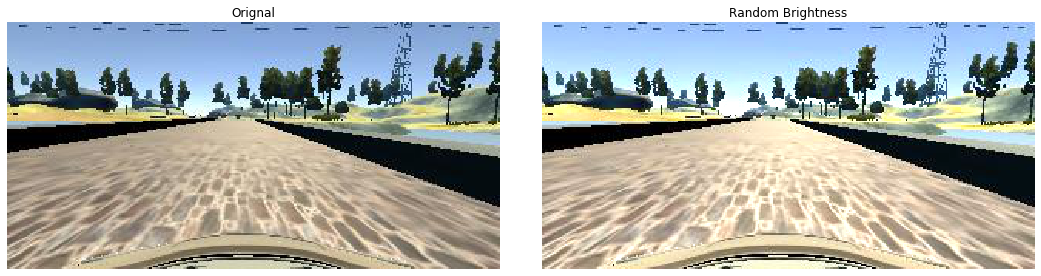

In [20]:
img = image_paths[random.randint(0, 1000)]
original_img = npimg.imread(img)
zoomed_img = img_random_brightness(original_img)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_img)
axis[0].axis('off')
axis[0].set_title('Orignal')
axis[1].imshow(zoomed_img)
axis[1].axis('off')
axis[1].set_title('Random Brightness')

#### Flipping the images

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) # 0 = vertical; 1=horizontal; -1=both
  steering_angle = -steering_angle
  return (image, steering_angle)

Text(0.5, 1, 'Flipped image Steering Angle:-0.0')

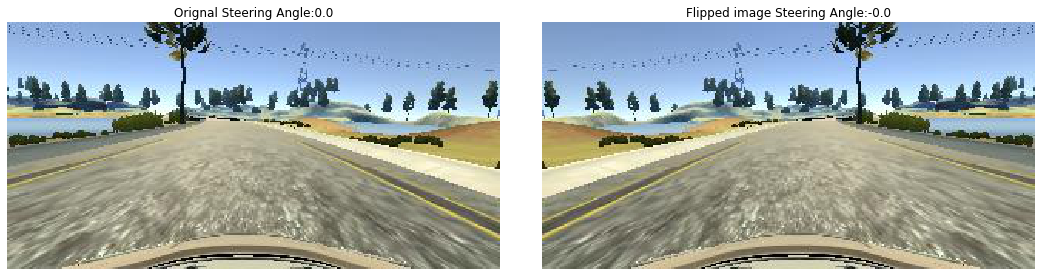

In [22]:
rand_index = random.randint(0, 1000)
img = image_paths[rand_index]
steering_angle = steerings[rand_index]
original_img = npimg.imread(img)
flipped_img, flipped_steering_angle = img_random_flip(original_img, steering_angle)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_img)
axis[0].axis('off')
axis[0].set_title('Orignal Steering Angle:' + str(steering_angle))
axis[1].imshow(flipped_img)
axis[1].axis('off')
axis[1].set_title('Flipped image Steering Angle:' + str(flipped_steering_angle))

#### random augmenter

In [0]:
def random_augment(image_path, steering_angle):
  image = npimg.imread(image_path)

  if (np.random.rand()) < 0.5:
    image = pan(image)
  
  if (np.random.rand()) < 0.5:
    image = zoom(image)
  
  if (np.random.rand()) < 0.5:
    image = img_random_brightness(image)

  if (np.random.rand()) < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  
  return (image, steering_angle)

In [24]:
ncol = 2
nrow = 10
fig, axis = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  rand_num = random.randint(0, len(image_paths)-1)
  random_image_path = image_paths[rand_num]
  random_steering_angle = steerings[rand_num]

  original_img = npimg.imread(random_image_path)
  augmented_img, steering_angle = random_augment(random_image_path, random_steering_angle)

  axis[i][0].imshow(original_img)
  axis[i][0].set_title('Original Image')
  axis[i][1].imshow(augmented_img)
  axis[i][1].set_title('Augmented Image')

Output hidden; open in https://colab.research.google.com to view.

## Image Preprocessing

In [0]:
def img_preprocess(img):
  # img = npimg.imread(img_path)

  # Focuse the image onto the road only **
  img = img[60:135, :, :]
  
  # YUV color space
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

  # Smoothing of the image
  img = cv2.GaussianBlur(img, (3, 3), 0)

  # resize
  img = cv2.resize(img, (200, 66))

  # normalise
  img = img/255

  return img

Text(0.5, 1, 'Preprocessed Image')

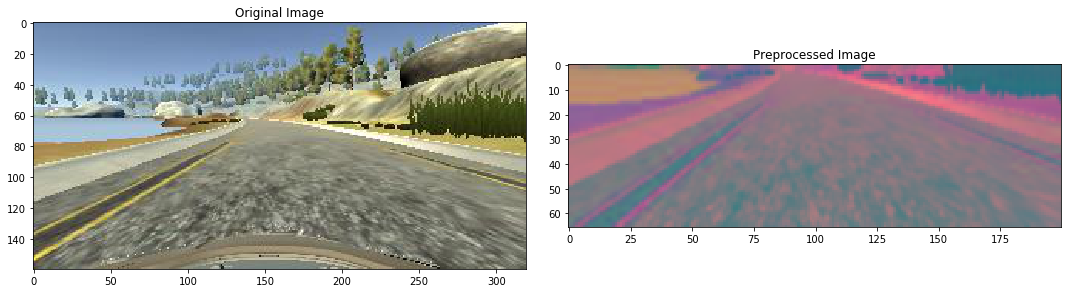

In [26]:
img_path = image_paths[100]
original_img = npimg.imread(img_path)
preprocessed_img = img_preprocess(original_img)

fig, axis = plt.subplots(1, 2, figsize = (15,10))
fig.tight_layout()
axis[0].imshow(original_img)
axis[0].set_title('Original Image')
axis[1].imshow(preprocessed_img)
axis[1].set_title('Preprocessed Image')

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = npimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1, 'Validation Image')

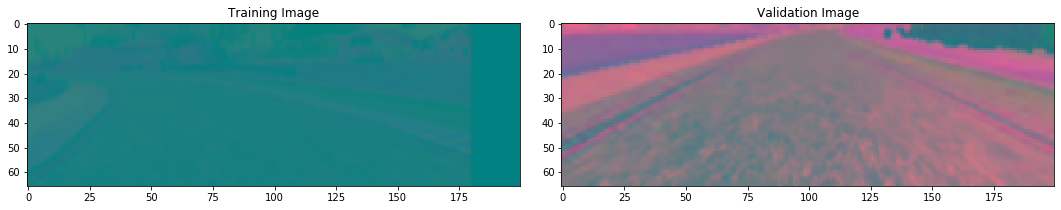

In [28]:
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
X_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, 0))

fig, axis = plt.subplots(1, 2, figsize = (15,10))
fig.tight_layout()
axis[0].imshow(X_train_gen[0])
axis[0].set_title('Training Image')
axis[1].imshow(X_val_gen[0])
axis[1].set_title('Validation Image')

In [0]:
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_val = np.array(list(map(img_preprocess, X_val)))

In [0]:
# plt.imshow(X_train[random.randint(0, len(X_train)-1)])
# plt.axis('off')
# print(X_train.shape)

<br />

# Nvidia Neural Network

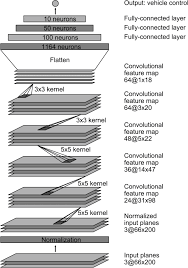

## Model definition

In [0]:
def nvidia_Model():
  model = Sequential()

  model.add(Convolution2D(24, 5,5, subsample=(2, 2), input_shape =(66, 200, 3), activation='elu')) # ** try adding padding
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1)) # This is different between a regression and classification model. Classification model generally has 'softmax' activation applied to calc prob of each class

  model.compile(Adam(lr = 1e-4), loss='mse', metrics=['accuracy'])

  return model

In [32]:
model = nvidia_Model()
print(model.summary())





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  if __name__ == '__main__':


## Model Training

In [33]:
h = model.fit_generator(batch_generator(X_train, y_train, batch_size=100, istraining=1),
                        steps_per_epoch=300, 
                        epochs=10, 
                        validation_data=batch_generator(X_val, y_val, batch_size=100, istraining=0), 
                        validation_steps=200, 
                        verbose=1, 
                        shuffle=1) 




Epoch 1/10





300/300 [==============================] - 190s 634ms/step - loss: 0.0914 - acc: 0.2580 - val_loss: 0.0584 - val_acc: 0.3273
Epoch 2/10
300/300 [==============================] - 180s 601ms/step - loss: 0.0728 - acc: 0.2653 - val_loss: 0.0616 - val_acc: 0.3232
Epoch 3/10
300/300 [==============================] - 178s 593ms/step - loss: 0.0708 - acc: 0.2689 - val_loss: 0.0533 - val_acc: 0.3336
Epoch 4/10
300/300 [==============================] - 178s 594ms/step - loss: 0.0673 - acc: 0.2686 - val_loss: 0.0507 - val_acc: 0.3452
Epoch 5/10
300/300 [==============================] - 178s 594ms/step - loss: 0.0597 - acc: 0.2677 - val_loss: 0.0507 - val_acc: 0.3463
Epoch 6/10
300/300 [==============================] - 179s 596ms/step - loss: 0.0561 - acc: 0.2775 - val_loss: 0.0439 - val_acc: 0.3505
Epoch 7/10
300/300 [==============================] - 178s 594ms/step - loss: 0.0533 - acc: 0.2802 - val_loss: 0.0412 - val_acc: 0.3563
Epoch 8/10
300/300 [====================

## Model Performance
### Loss visualisation

Text(0.5, 1.0, 'Loss')

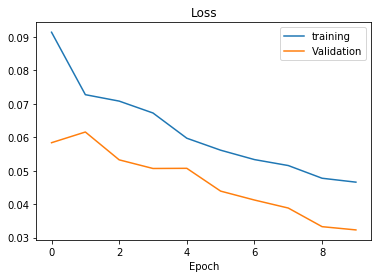

In [34]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'Validation'])
plt.xlabel('Epoch')
plt.title('Loss')

# Visualising the Neural Network

(1, 66, 200, 3)


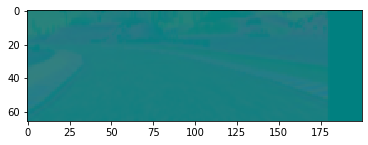

In [45]:
print(X_train_gen.shape)
plt.imshow(X_train_gen[0])
image = X_train_gen

In [46]:
layer1 = Model(inputs=model.layers[0].input, outputs = model.layers[0].output)
layer2 = Model(inputs=model.layers[0].input, outputs = model.layers[1].output)
layer3 = Model(inputs=model.layers[0].input, outputs = model.layers[2].output)
layer4 = Model(inputs=model.layers[0].input, outputs = model.layers[3].output)
layer5 = Model(inputs=model.layers[0].input, outputs = model.layers[4].output)

visual_layer1 = layer1.predict(image)
visual_layer2 = layer2.predict(image)
visual_layer3 = layer3.predict(image)
visual_layer4 = layer4.predict(image)
visual_layer5 = layer5.predict(image)

print(visual_layer1.shape)
print(visual_layer2.shape)

(1, 31, 98, 24)
(1, 14, 47, 36)


Convolution Layer 1 24 filters


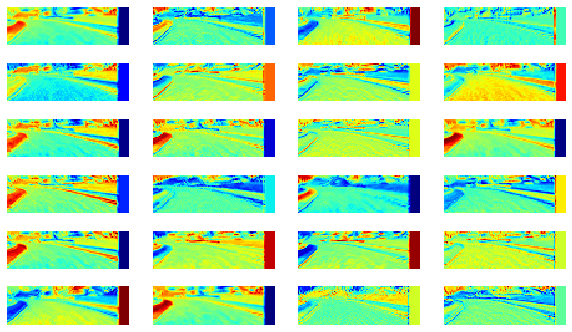

In [52]:
plt.figure(figsize=(10, 6))
for i in range(24):
  plt.subplot(6, 4, i+1)
  plt.imshow(visual_layer1[0, :, :, i], cmap=plt.get_cmap('jet'))
  plt.axis('off')

print('Convolution Layer 1 24 filters')

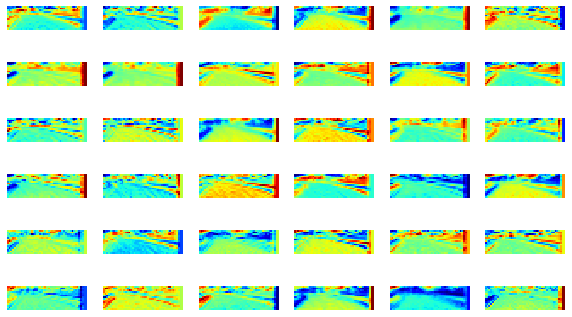

In [48]:
plt.figure(figsize=(10, 6))
for i in range(36):
  plt.subplot(6, 6, i+1)
  plt.imshow(visual_layer2[0, :, :, i], cmap=plt.get_cmap('jet'))
  plt.axis('off') 

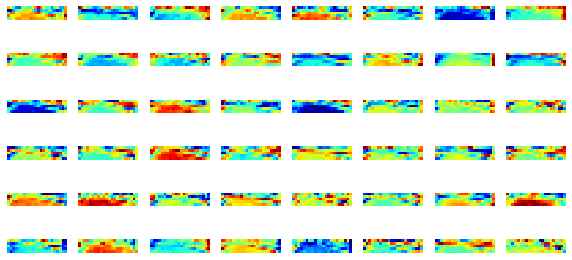

In [61]:
plt.figure(figsize=(10, 5))
for i in range(48):
  plt.subplot(6, 8, i+1)
  plt.imshow(visual_layer3[0, :, :, i], cmap=plt.get_cmap('jet'))
  plt.axis('off') 

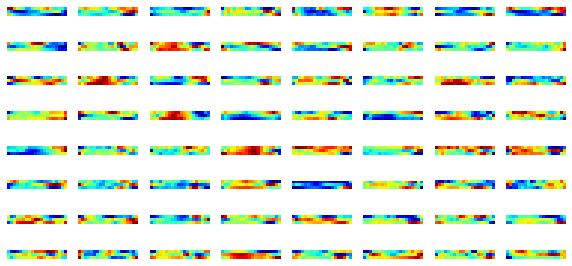

In [60]:
plt.figure(figsize=(10, 5))
for i in range(64):
  plt.subplot(8, 8, i+1)
  plt.imshow(visual_layer4[0, :, :, i], cmap=plt.get_cmap('jet'))
  plt.axis('off') 

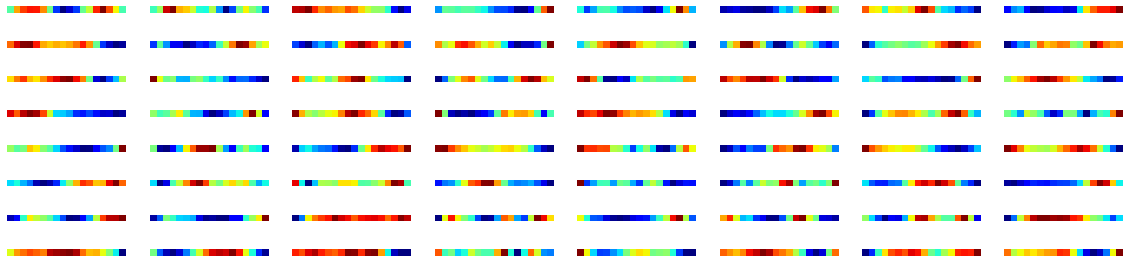

In [59]:
plt.figure(figsize=(20, 5))
for i in range(64):
  plt.subplot(8, 8, i+1) # (nrwo, ncol, index)
  plt.imshow(visual_layer5[0, :, :, i], cmap=plt.get_cmap('jet'))
  plt.axis('off') 

# Export the model

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')